In [1]:
import numpy as np
import open3d as o3d
import copy
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

## File IO

In [2]:
stl_mesh = o3d.io.read_triangle_mesh("models/stl_mesh.stl")
obj_mesh = o3d.io.read_triangle_mesh("models/obj_mesh.obj")
mesh = obj_mesh

## Normalization

### Center the Mesh

In [3]:
print(mesh.get_center())
centered_vertices = np.array(mesh.vertices) - mesh.get_center()
mesh.vertices = o3d.utility.Vector3dVector(centered_vertices)
print(mesh.get_center())

[ 0.72569102 -0.68593362 10.31785828]
[-7.68295749e-13 -6.04510797e-13 -5.92657940e-12]


### Scale the Points

In [4]:
print(mesh.get_min_bound(), mesh.get_max_bound())
mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
print(mesh.get_min_bound(), mesh.get_max_bound())

[-33.08519572  -4.25436637 -42.67735916] [31.63381368  2.27343359 75.54260773]
[-0.27986132 -0.03598687 -0.36099959] [0.26758436 0.01923054 0.63900041]


## Normals Visualization

In [5]:
# print(np.array(stl_mesh.vertices).shape)
# print(np.array(stl_mesh.triangles).shape)
# print(np.array(stl_mesh.vertex_normals).shape)
# print(np.array(stl_mesh.triangle_normals).shape)
# print(stl_mesh.has_triangle_normals())
# print(stl_mesh.has_vertex_normals())

# print(stl_mesh.compute_triangle_normals())
# print(stl_mesh.compute_vertex_normals())

In [6]:
mesh.compute_triangle_normals()
triangle_normals = np.array(mesh.triangle_normals)

indices = list(range(0, triangle_normals.shape[0], 20))
triangle_normals_subset = triangle_normals[indices]

fromm = [0] * triangle_normals_subset.shape[0]
to = list(range(1, triangle_normals_subset.shape[0] + 1))

points = np.insert(triangle_normals_subset, 0, [0, 0, 0], axis=0)
lines = list(zip(fromm, to))


line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector(lines)
)

line_set.scale(1.2, [0, 0, 0])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])
o3d.visualization.draw_geometries([mesh, line_set])

## Defects Rotation

### Hole through Min MOI Axis

In [26]:
# get the voxel grid indices out of the occupancy grid
model = np.load("models/top_20_models_voxelized/14.npz")['model']
voxels = np.argwhere(model == 1)

In [27]:
points = np.asarray(voxels)
points_squared = np.square(points)

In [28]:
# horizontal sum of Y and Z components
I_xx = points_squared[:, 1:].sum(axis=1)
# vertical sum
I_xx = I_xx.sum(axis=0)

# horizontal product of X and Y components
I_xy = points[:, 0] * points[:, 1]
# vertical sum
I_xy = -I_xy.sum(axis=0)

# horizontal product of X and Z components
I_xz = points[:, 0] * points[:, 2]
# vertical sum
I_xz = -I_xz.sum(axis=0)

# horizontal sum of X and Z components
I_yy = points_squared[:, 0] + points_squared[:, 2]
# vertical sum
I_yy = I_yy.sum(axis=0)

# horizontal product of Y and Z components
I_yz = points[:, 1] * points[:, 2]
# vertical sum
I_yz = -I_yz.sum(axis=0)

# horizontal sum of X and Y components
I_zz = points_squared[:, 0] + points_squared[:, 1]
# vertical sum
I_zz = I_zz.sum(axis=0)

In [29]:
inertia_tensor = np.array([[I_xx, I_xy, I_xz], [I_xy, I_yy, I_yz], [I_xz, I_yz, I_zz]])
eigen_values, eigen_vectors = np.linalg.eigh(inertia_tensor)
min_eigen_value_index = eigen_values.argmin()
min_MOI_axis = eigen_vectors[:, min_eigen_value_index]

In [30]:
def align_vectors_v2(a, b):
    a = a / np.linalg.norm(a) # normalize a
    b = b / np.linalg.norm(b) # normalize b
    v = np.cross(a, b)
    s = np.linalg.norm(v)
    c = np.dot(a, b)

    v1, v2, v3 = v
    h = 1 / (1 + c)

    Vmat = np.array([[0, -v3, v2],
                  [v3, 0, -v1],
                  [-v2, v1, 0]])

    R = np.eye(3, dtype=np.float64) + Vmat + (Vmat.dot(Vmat) * h)
    return R

In [31]:
axis = np.array([0., 1., 0.])
rotation = align_vectors_v2(min_MOI_axis, axis)

In [32]:
min_MOI_axis = rotation.dot(min_MOI_axis)
voxels = np.round(voxels.dot(rotation)).astype(int)

In [33]:
N = voxels.max()
voxels_occ_grid = np.zeros((N,N,N))

In [34]:
for v in voxels:
    voxels_occ_grid[v[0]-1, v[1]-1, v[2]-1] = 1

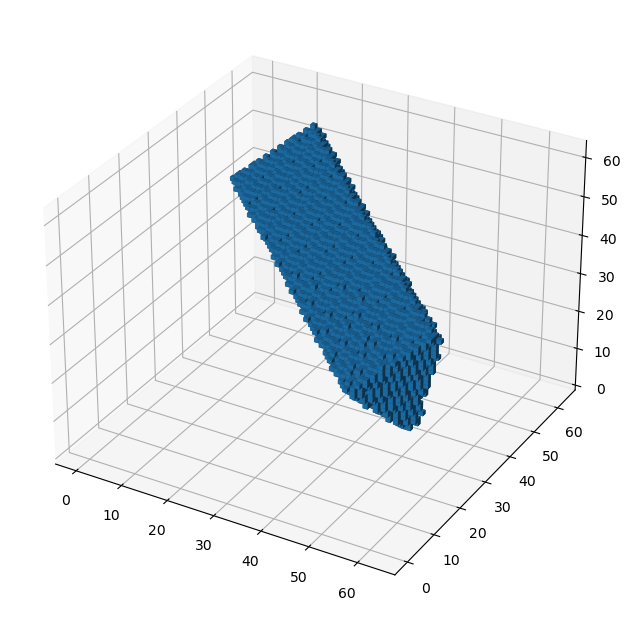

In [35]:
fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')
ax.voxels(voxels_occ_grid)
plt.show()